In [61]:
import ROOT as r
r.EnableImplicitMT()

from xgboost import XGBClassifier, plot_importance
import numpy as np
import pandas as pd

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

import hist
from matplotlib import pyplot as plt
import mplhep as hep
hep.style.use(hep.style.CMS)

In [153]:
def load_data(signal_filename, background_filename):
    variables = ["VBSjet1pt", "VBSjet1eta", "VBSjet1phi", "VBSjet2pt", "VBSjet2eta", "VBSjet2phi", "VBSMjj", "VBSdetajj", "weight"]

    def pddf(filename, variables):
        data = r.RDataFrame("Events", filename).Filter("weight > 0").Filter("passCut7").AsNumpy(variables)
        return pd.DataFrame(data)
    
    x_sig = pddf(signal_filename, variables)
    x_bkg = pddf(background_filename, variables)

    x_sig["weight"] = x_sig["weight"] / max(x_sig["weight"])
    x_bkg["weight"] = x_bkg["weight"] / max(x_bkg["weight"])

    x_sig["label"] = 1
    x_bkg["label"] = 0

    df = pd.concat([x_sig, x_bkg], ignore_index=True)
    df = df.sample(frac=1).reset_index(drop=True)

    return df

In [154]:
# df = load_data("/data/userdata/aaarora/output/run2/sig.root", "/data/userdata/aaarora/output/run2/bkg.root")
df = load_data("/ceph/cms/store/user/aaarora/output/sig.root", "/ceph/cms/store/user/aaarora/output/bkg.root")

X = df.drop(columns=["label", "weight"]).to_numpy()
y = df["label"].to_numpy()
w = df["weight"].to_numpy()

In [155]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.2, random_state=42)

In [209]:
params = {
    "objective": "binary:logistic",
    "device": "cuda:1",
    "eval_metric": "auc",
    "tree_method": "approx",
    "n_estimators": 200,
    "max_depth": 4,
    "min_child_weight": 1,
    "colsample_bytree": 1,
    "colsample_bylevel": 1,
    "subsample": 1,
    "learning_rate": 0.1,
    "lambda": 0.1,
    "alpha": 0.1,
    "gamma": 0,
    "nthread": 128,
}
bdt = XGBClassifier(**params)

In [210]:
bdt.fit(X_train, y_train, sample_weight=w_train, eval_set=[(X_test, y_test)], verbose=True)

[0]	validation_0-auc:0.92728
[1]	validation_0-auc:0.93294
[2]	validation_0-auc:0.93522


[3]	validation_0-auc:0.93782
[4]	validation_0-auc:0.93834
[5]	validation_0-auc:0.93857
[6]	validation_0-auc:0.93914
[7]	validation_0-auc:0.93938
[8]	validation_0-auc:0.93990
[9]	validation_0-auc:0.94097
[10]	validation_0-auc:0.94101
[11]	validation_0-auc:0.94107
[12]	validation_0-auc:0.94146
[13]	validation_0-auc:0.94178
[14]	validation_0-auc:0.94200
[15]	validation_0-auc:0.94231
[16]	validation_0-auc:0.94264
[17]	validation_0-auc:0.94259
[18]	validation_0-auc:0.94267
[19]	validation_0-auc:0.94275
[20]	validation_0-auc:0.94284
[21]	validation_0-auc:0.94285
[22]	validation_0-auc:0.94299
[23]	validation_0-auc:0.94310
[24]	validation_0-auc:0.94335
[25]	validation_0-auc:0.94339
[26]	validation_0-auc:0.94336
[27]	validation_0-auc:0.94371
[28]	validation_0-auc:0.94376
[29]	validation_0-auc:0.94384
[30]	validation_0-auc:0.94392
[31]	validation_0-auc:0.94393
[32]	validation_0-auc:0.94396
[33]	validation_0-auc:0.94409
[34]	validation_0-auc:0.94412
[35]	validation_0-auc:0.94431
[36]	validation_0

XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
              device='cuda:1', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.1, learning_rate=0.1,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, ...)

In [211]:
y_pred = bdt.predict_proba(X_test)[:, 1]

In [212]:
false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_pred)
score = auc(false_positive_rate, true_positive_rate)

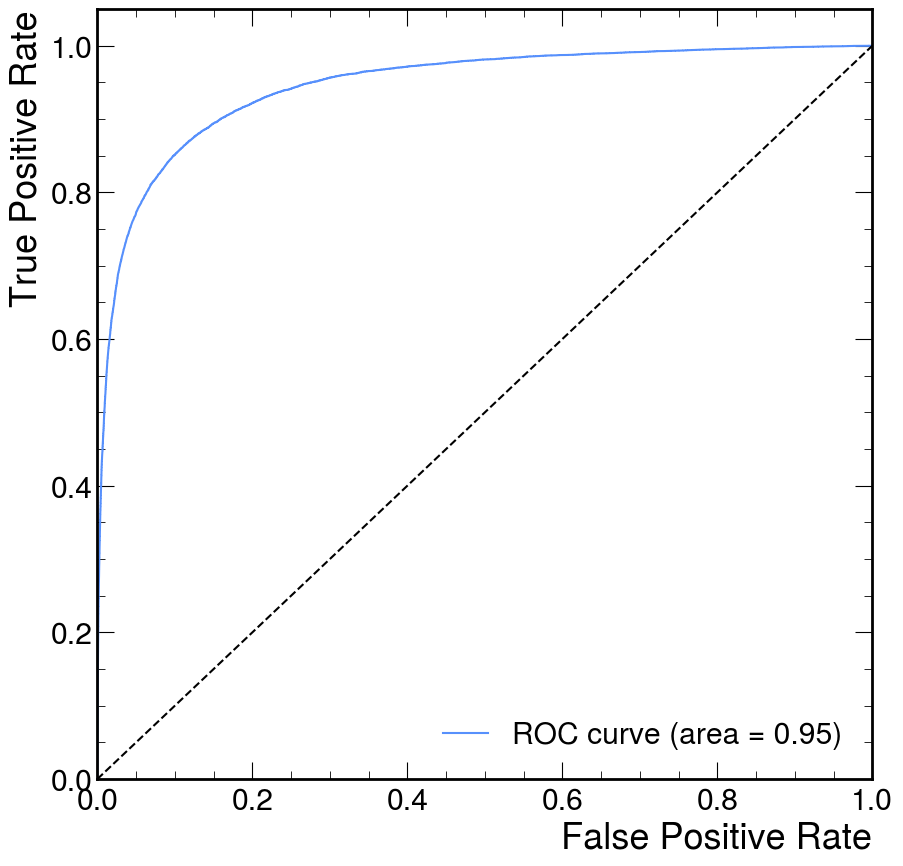

In [213]:
fig, ax = plt.subplots()
ax.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % score)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

[Text(0, 0, 'VBSjet1pt'),
 Text(0, 1, 'VBSjet1eta'),
 Text(0, 2, 'VBSjet1phi'),
 Text(0, 3, 'VBSjet2pt'),
 Text(0, 4, 'VBSjet2eta'),
 Text(0, 5, 'VBSjet2phi'),
 Text(0, 6, 'VBSMjj'),
 Text(0, 7, 'VBSdetajj')]

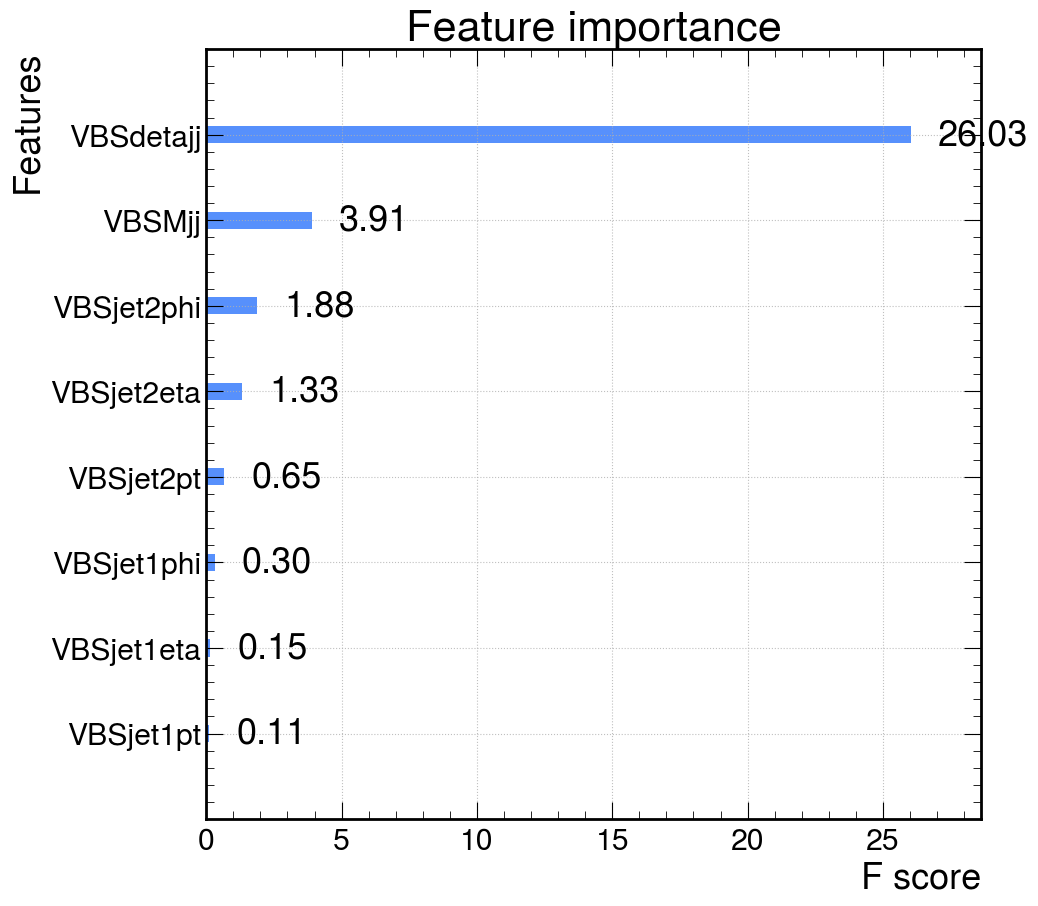

In [214]:
plot_importance(bdt, max_num_features=None, importance_type="gain", values_format="{v:.2f}").set_yticklabels(["VBSjet1pt", "VBSjet1eta", "VBSjet1phi", "VBSjet2pt", "VBSjet2eta", "VBSjet2phi", "VBSMjj", "VBSdetajj"])

In [215]:
r.TMVA.Experimental.SaveXGBoost(bdt, "VBSBDT", "BDT_Weights.root", num_inputs=X.shape[1])

# Validation

In [216]:
bdt = r.TMVA.Experimental.RBDT("VBSBDT", "/home/users/aaarora/phys/analysis/vbs-1lep/mva/training/BDT/BDT_Weights.root")

Text(0, 1, 'Density')

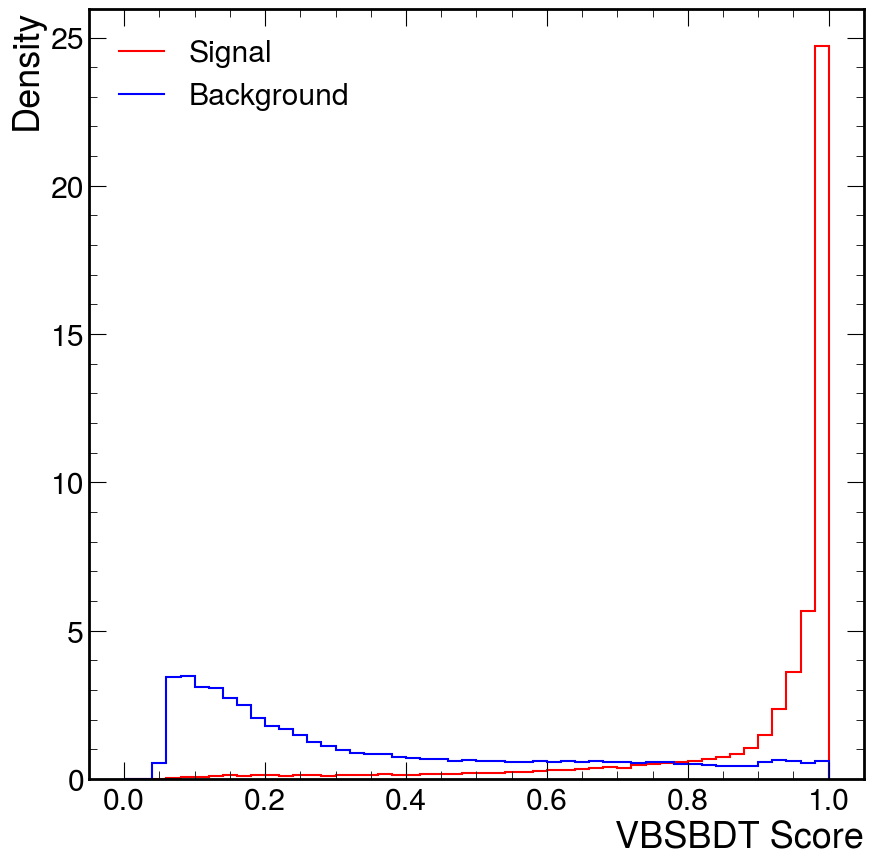

In [217]:
h1 = hist.Hist.new.Reg(50, 0, 1, name="SIG", label="SIG").Double()
h1.fill(bdt.Compute(X[y==1]).flatten(), weight=w[y==1])

h2 = hist.Hist.new.Reg(50, 0, 1, name="BKG", label="BKG").Double()
h2.fill(bdt.Compute(X[y==0]).flatten(), weight=w[y==0])

fig, ax = plt.subplots()
hep.histplot(h1, ax=ax, label="Signal", color="red", density=True)
hep.histplot(h2, ax=ax, label="Background", color="blue", density=True)

ax.legend()
ax.set_xlabel("VBSBDT Score")
ax.set_ylabel("Density")